# Portfolio optimization
An investor whats to optimize the asset allocation of his investment

Variables: $X_i$, $i=1,2,3,4$ the asset contribution

Constrints: 
- $sum_i X_i \leq $MAXINVEST
- $sum_i X_i  R_i \leq $ MAXRISK

where $R_i=\text{RISKFACTOR}$ for the asset $i$

Objective: $sum_i X_i * $ RETURN

The risk factor $R_i$ is a random variable. So wee need to perform several monte carlo simulations optimizing for different values the objective.

In [1]:
library(data.table)
library(lpSolveAPI)
library(ggplot2)

MAXINVEST = 100000
MAXRISK = 100000
MAXITER = 10000



assets = c( 0.04,0.05,2500.00,5000.00,-0.30,
            0.11,0.04, 15000.00,  NA,   2.10 ,    0.08 ,0.01,
             30000.00 ,      NA,     1.80 ,    0.01 ,      NA,  
             NA,     NA ,   -0.50)
assets = t(array(assets, dim=c(5,4)))

rownames(assets) = c('Bonds','Stock','MutualFunds','MoneyMarket')
colnames(assets) = c('ParamA','ParamB','Minimum','Maximum',
                     'RiskFactor')
assets

,ParamA,ParamB,Minimum,Maximum,RiskFactor
Bonds,0.04,0.05,2500,5000,-0.3
Stock,0.11,0.04,15000,NA,2.1
MutualFunds,0.08,0.01,30000,NA,1.8
MoneyMarket,0.01,NA,NA,NA,-0.5


In [2]:
#Simulate returns
returns = cbind(runif(MAXITER,assets['Bonds','ParamA'],assets['Bonds','ParamB']),
                log(rlnorm(MAXITER,(assets['Stock','ParamA']),assets['Stock','ParamB'])),
                rnorm(MAXITER,assets['MutualFunds','ParamA'],assets['MutualFunds','ParamB']),
                0.01)
colnames(returns) = rownames(assets)
head(returns)

Bonds,Stock,MutualFunds,MoneyMarket
0.04290096,0.1180926,0.08255724,0.01
0.04442484,0.1397853,0.09397104,0.01
0.04490051,0.1284470,0.07948420,0.01
0.04920954,0.1466361,0.05994281,0.01
0.04964647,0.1234490,0.08760823,0.01
0.04739621,0.1926628,0.08927686,0.01


In [3]:
#Build model
nVar = nrow(assets)
nCtr = 2
lprec <- make.lp(nCtr,nVar)



In [4]:
#write constraints and bounds
row_ub = matrix(NA, nrow = nCtr)
row_lb = matrix(NA, nrow = nCtr)

row_ub[1] = MAXINVEST
set.row(lprec, 1, rep(1,nVar),
          indices = 1:nVar)

row_ub[2] = MAXRISK
set.row(lprec, 2, assets[,'RiskFactor'],
        indices = 1:nVar)


col_lb = assets[,'Minimum']
col_lb[is.na(col_lb)] = 0
col_ub = assets[,'Maximum']
set.constr.value(lprec, lhs = row_lb, rhs = row_ub, 1:nCtr)
set.bounds(lprec, lower = col_lb, upper = col_ub, columns = 1:nVar)
lp.control(lprec, sense = "max")




$anti.degen
[1] "fixedvars" "stalling" 

$basis.crash
[1] "none"

$bb.depthlimit
[1] -50

$bb.floorfirst
[1] "automatic"

$bb.rule
[1] "pseudononint" "greedy"       "dynamic"      "rcostfixing" 

$break.at.first
[1] FALSE

$break.at.value
[1] 1e+30

$epsilon
      epsb       epsd      epsel     epsint epsperturb   epspivot 
     1e-10      1e-09      1e-12      1e-07      1e-05      2e-07 

$improve
[1] "dualfeas" "thetagap"

$infinite
[1] 1e+30

$maxpivot
[1] 250

$mip.gap
absolute relative 
   1e-11    1e-11 

$negrange
[1] -1e+06

$obj.in.basis
[1] TRUE

$pivoting
[1] "devex"    "adaptive"

$presolve
[1] "none"

$scalelimit
[1] 5

$scaling
[1] "geometric"   "equilibrate" "integers"   

$sense
[1] "maximize"

$simplextype
[1] "dual"   "primal"

$timeout
[1] 0

$verbose
[1] "neutral"

In [15]:
simResults = c()

#Run simulations
for(iter in 1:MAXITER){
  
  set.objfn(lprec, returns[iter,])
  solve.lpExtPtr(lprec)
  sols <- get.variables(lprec)
  maximize <- get.objective(lprec)
  
  simResults = rbind(simResults, c(sols,maximize))
  
}


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


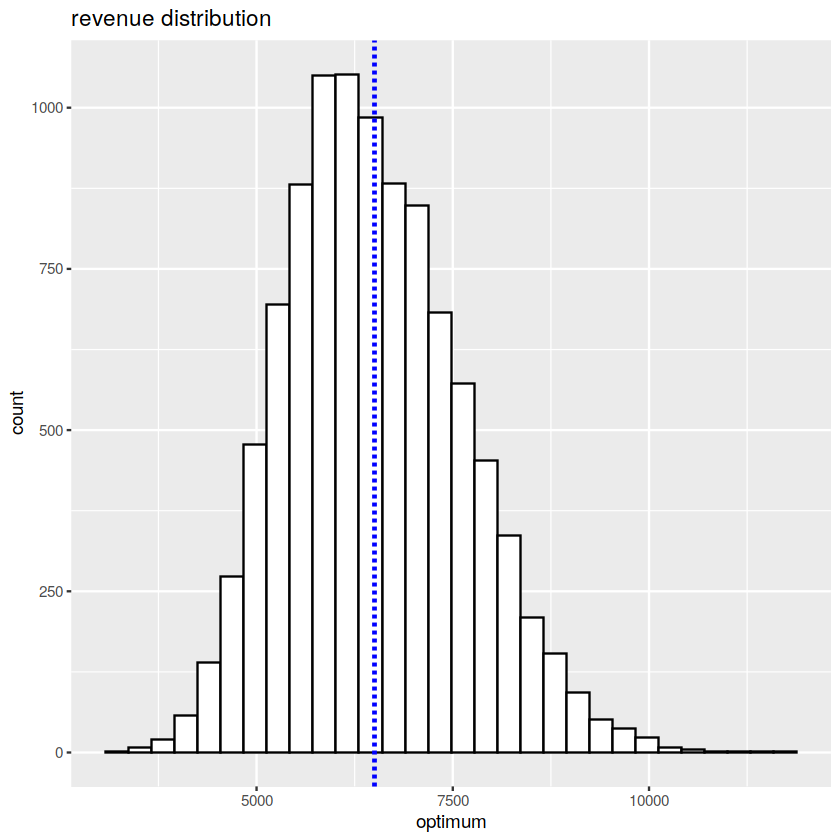

In [19]:
simResults = data.table(simResults)
colnames(simResults) = c(row.names(assets), 'optimum')
p<-ggplot(simResults, aes(x=optimum)) + 
  geom_histogram(color="black", fill="white") + labs(title = 'revenue distribution')
p+ geom_vline(aes(xintercept=mean(simResults[['optimum']])),
            color="blue", linetype="dashed", size=1)


In [30]:
summary(simResults)

     Bonds          Stock        MutualFunds     MoneyMarket       optimum     
 Min.   :5000   Min.   :15000   Min.   :30000   Min.   :32174   Min.   : 3263  
 1st Qu.:5000   1st Qu.:15000   1st Qu.:30000   1st Qu.:32174   1st Qu.: 5703  
 Median :5000   Median :30769   Median :30000   Median :34231   Median : 6405  
 Mean   :5000   Mean   :26075   Mean   :35307   Mean   :33618   Mean   : 6508  
 3rd Qu.:5000   3rd Qu.:30769   3rd Qu.:47826   3rd Qu.:34231   3rd Qu.: 7232  
 Max.   :5000   Max.   :30769   Max.   :47826   Max.   :34231   Max.   :11768  